---
# Examples of 2-D classifications using AdaBoost

In this script, we implement a version of the AdaBoost algorithm. We use it to classify a binary dataset made of 
two overlapping ellipsoidal gaussian distributions. The class labels are $\{-1, +1\}$ instead of the standard $\{0, 1\}$.

## The idea behind de AdaBoost algorithm (with binary output)

The core idea is to combine several unstable binary classifiers $y_{m}(\bf{x})$ with poor 
accuracies such that each one slightly compensates the errors of the others. The final classifier
becomes:

<blockquote>  $Y_{M}(x) = sign\{\sum _{m=1}^{M} \alpha_{m} y_{m}(x)\}$</blockquote>

Since each classifier outputs a $\pm 1$, the sign function acts as a majority detector. 

The $y_{m}(\bf{x})$ classifiers are called weak learners. They perform poorly with classification errors 
$\epsilon \lt 50\%$ so they cannot reduce the cumulative accuracy. They are unstable because their 
classification results may vary widly when the training data change only slightly. 

It seems counter-intuitive to use such weak learners but each new one is trained on data
that could not be classified properly by the previous ones. The new one can still classify some of those data and the hopeless 
cases are given to the next-in-line learner and so on.   


Each weak learner is optimized to reduce the average error 

<blockquote>  $\epsilon_{m} = \sum _{n=1}^{N} w_{n}^{(m)}I(y_{m}(x_{n})\neq t_{n})$</blockquote>  

where $t_{n}$ is the class label of $\bf{x}_{n}$, $w_{n}^{(m)}$ is the normalized weight assigned to $\bf{x}_{n}$, and 
                                                               
                                                               
<blockquote> 
$I(y_{m}(x_{n})\neq t_{n})=\left\{
    \begin{array}{ll}
      1, & \mbox{if $y_{m}(x_{n})\neq t_{n}$}.\\
      0, & \mbox{otherwise}.
    \end{array}
  \right.$                                            
</blockquote> 
      
    
The average error is combined with a learning rate $\lambda$ to produce the weighting factor $\alpha_{m}$ assigned to the 
weak learner $y_{m}(\bf{x})$. 
    
<blockquote>  $\large{\alpha_{m} = \lambda \ln{\{\frac{1-\epsilon_{m}}{\epsilon_{m}}\}}}$</blockquote> 
    
The value of $\alpha_{m}$ is a measure of the contribution of the estimator $y_{m}(\bf{x})$ to the final AdaBoost classifier $Y_{M}(x)$.


The secret ingredient in the AdaBoost sauce is the specific weight adjustment for misclassified data only. 
The weights are updated using the factor $\alpha_{m}$ according to


<blockquote>  $w_{n}^{(m+1)} = w_{n}^{(m)} \exp{\{\alpha_{m} I(y_{m}(x_{n})\neq t_{n})\}}$</blockquote>  

Only the misclassified data, for which $y_{m}(x_{n})\neq t_{n}$, have their weights increased. 
The others get reduced weights after weight normalization: 

<blockquote>  $\large{w_{n}^{(m+1)} = \frac{w_{n}^{(m+1)}}{\sum _{n=1}^{N} w_{n}^{(m+1)}}}$</blockquote>  



## Algorithm implementation 
To summarize, we use the algorithm described in the book $\textit{Pattern Recognition and Machine Learning}$ by 
Christopher Bishop, (pp. 658-659). N.B. The learning rate $\lambda$ was introduced in the equation for the 
weighting factor $\alpha$.
    
<ol>
<li>
    <blockquote>  Initialise the weights $w_{n}^{(1)} = 1/N$ for $n=1,\cdots,N$  </blockquote> 
<li>
    <blockquote> For $m=1,\cdots,M$ 
    <ol>
    <li>
    Train a weak learner on the data to minimize the average error 
    <blockquote> $\epsilon_{m} = \sum _{n=1}^{N} w_{n}^{(m)}I(y_{m}(x_{n})\neq t_{n})$</blockquote>  
    <li>    
    Compute the weighting factor
    <blockquote>  $\large{\alpha_{m} = \lambda \ln{\{\frac{1-\epsilon_{m}}{\epsilon_{m}}\}}}$ </blockquote> 
    <li>
    Update the weights
    <blockquote>  $w_{n}^{(m+1)} = w_{n}^{(m)} \exp{\{\alpha_{m} I(y_{m}(x_{n})\neq t_{n})\}}$ </blockquote>
    <li>
    Normalize the weights
    <blockquote>  $\large{w_{n}^{(m+1)} = \frac{w_{n}^{(m+1)}}{\sum _{n=1}^{N} w_{n}^{(m+1)}}}$</blockquote> </blockquote> 
    </li>

<li>    
    <blockquote> Compute the cumulative model </blockquote>
    <blockquote>  $Y_{M}(x) = sign\{\sum _{m=1}^{M} \alpha_{m} y_{m}(x)\}$ </blockquote> 
</li>
</ol>

In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import random
import seaborn as sns
sns.set(color_codes=True)

# Used for reproductibility of the results
np.random.seed(43)

Automatically created module for IPython interactive environment


### Generate dataset

The dataset is made of two 2-D ellipsoidal gaussian distributions with a small number of datapoints to 
better show the features of the AdaBoost algorithm. 

In [2]:
X, y = make_classification(n_samples=30, n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

# Convert {0, 1} to {-1, 1} classes
y = 2*y-1

Display the dataset

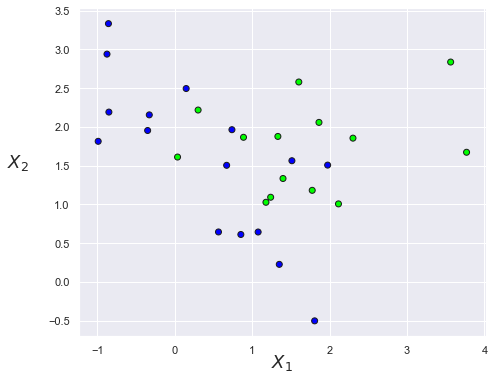

In [3]:
cm_bright = ListedColormap(['#00FF00', '#0000FF']) 

fig, ax = plt.subplots(figsize = (7, 7))     
ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, edgecolors='k')
ax.set_xlabel('$X_1$',fontsize=18)
ax.set_ylabel('$X_2$',fontsize=18, rotation=0)
ax.xaxis.set_label_coords(0.5, -0.05) 
ax.yaxis.set_label_coords(-0.15, 0.5) 
ax.set_aspect('equal')
fig.tight_layout()

plt.savefig('12.1.1_dataset_to_classity.png')
plt.savefig('12.1.1_dataset_to_classity.pdf')

### Preprocess dataset, split into training and test part

In [4]:
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

### Implementation of the AdaBoost classifier 
We use Decision-Tree Classifiers as weak learners. We also use a learning rate $\lambda$ for visual 
purposes; it helps to understand how the weak learners and the AdaBoost errors are related. 

A basic version of AdaBoost algorithm is implemented without special optimization or data handling. 

In [5]:
def AdaBoost(X_train, y_train, n_estimators, learning_rate):

    # The training results for each weak learner will be saved
    classifiers_list, errors_list, alphas_list, weights_list = [], [], [], []

    # Initialise weights to 1/N
    N = len(y_train)    
    weights = np.ones(N) / N
    
    for k in range(n_estimators):
        # Define the weak learner template
        clf = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        
        # Train the classifier using a resampling of the dataset based on the individual weights
        clf.fit(X_train, y_train, sample_weight=weights)

        # Predict class for original dataset
        y_pred = clf.predict(X_train)
        
        # Find the samples with bad predictions
        bad_predictions = (y_pred!=y_train)

        # Mean training error
        error = np.average(bad_predictions, weights=weights)
        
        if (error>0.5):
            # Stop if the mean error is greater than 50% and discard the last classifier results
            return (classifiers_list, errors_list, weights_list, alphas_list)

        # Weighting factor alpha for boosting weights of hard-to-classify data. 
        # N.B. The learning rate is integrated within alpha 
        alpha = learning_rate * np.log((1. - error) / error)
        
        # Bookkeeping
        classifiers_list.append(clf)
        errors_list.append(error)
        alphas_list.append(alpha) 
        weights_list.append(weights.copy()) 

        # Only update the weights of the samples with bad predictions and normalize them all.
        weights = np.where(bad_predictions, weights*np.exp(alpha), weights)
        weights = weights/np.sum(weights)
        
    return (classifiers_list, errors_list, weights_list, alphas_list)



## Train the AdaBoost classifier
We use a learning rate of $\lambda=0.3$ to better show the optimization process.

In [6]:
n_estimators = 100
learning_rate = .3
(classifiers_list, errors_list, weights_list, alpha_list) = AdaBoost(X_train, y_train, n_estimators, learning_rate)


## Display the mean training error and the weighting factor $\alpha$ for each weak learner
Successive estimators have an increasing mean error rate (left panel) but never reach the critical 50% value. 

The mean error is not smoothly increasing. A new estimator might do better on some difficult data but 
do worse on other data that were previously correctly classified. Overall, the error increases nevertheless because the 
easy-to-classify data are given negligible weights and each weak learner must concentrate on the remaining 
hard-to-classify data which have more weights in the balance.

The weighting factor $\alpha$ in the right panel shows a downhill trend. The importance of successive 
estimators slowly drops over the iterations. Thus, the rough classification performances are 
mostly carved out by the first estimators and the final polishing is made by the later estimators.  

In both panels the curves show an initial exponential phase followed by a steady state oscillatory behaviour where 
the new estimators improve on some data and degrade on others in a cyclic pattern.

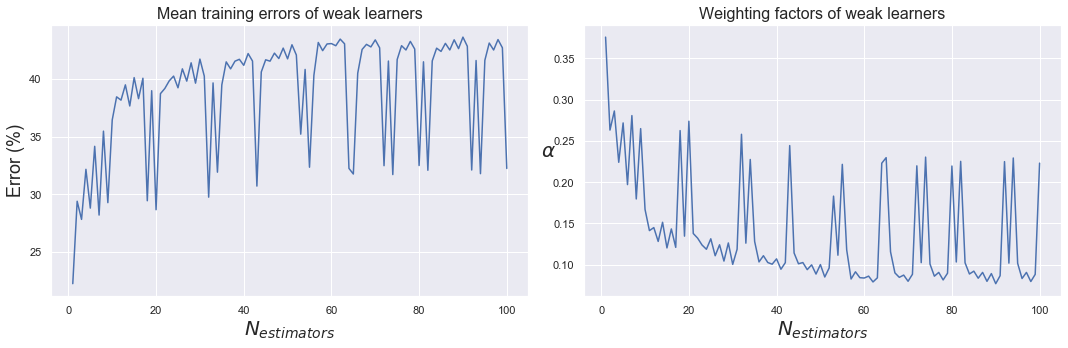

In [7]:
n_estimators = np.arange(1,len(classifiers_list)+1)
err = 100*np.array(errors_list)

fig, axs = plt.subplots(1,2,figsize = (15, 5))
axs[0].plot(n_estimators, err)
axs[0].set_xlabel('$N_{estimators}$',fontsize=20)
axs[0].set_ylabel('Error (%)',fontsize=18)
axs[0].set_title('Mean training errors of weak learners',fontsize=16)

axs[1].plot(n_estimators, alpha_list)
axs[1].set_xlabel('$N_{estimators}$',fontsize=20)
axs[1].set_ylabel(r'$\alpha$',fontsize=20, rotation=0)
axs[1].set_title('Weighting factors of weak learners',fontsize=16)

fig.tight_layout()

plt.savefig('12.1.2_weak_learner_errors_and_alpha_factors_lambda_0.3.png')
plt.savefig('12.1.2_weak_learner_errors_and_alpha_factors_lambda_0.3.pdf')

## How do the AdaBoost training and test performances vary with the number of estimators?

Let us create a function that computes the training and test scores at each interation (when a new estimator is added).

In [8]:
def AdaBoost_scores(classifiers, alpha, X_train, y_train, X_test, y_test):
    
    score_train = np.zeros(len(classifiers))
    score_test = np.zeros(len(classifiers))
    
    sum_train = 0.
    sum_test = 0.
    for k, clf in enumerate(classifiers):
        y = clf.predict(X_train)
        sum_train += alpha[k]*y
        y_pred = np.sign(sum_train)
        score_train[k] = metrics.accuracy_score(y_train, y_pred)

        y = clf.predict(X_test)
        sum_test += alpha[k]*y
        y_pred = np.sign(sum_test)
        score_test[k] = metrics.accuracy_score(y_test, y_pred)
           
    return (score_train, score_test)

Get the AdaBoost scores over the iterations.

In [9]:
(score_train, score_test) = AdaBoost_scores(classifiers_list, alpha_list, X_train, y_train, X_test, y_test)

The next figure displays the AdaBoost training and test scores for increasing number of estimators. 
The blue curve shows a typical AdaBoost behaviour where the score on training data reaches an amazing 100%. The most 
important result however is the score on test data. The orange curve shows that it changes from 50% to 83%! This 
is quite substantial considering that we are combining series of weak learners.

Both rough-looking curves increase or decrease over successive estimators but eventually level-out around 
iteration 65. This is where the exponential phases end in the last figure. Beyond that point, the new estimators 
improve on some data and degrade on others in a cyclic pattern; the final scores no longer change. 


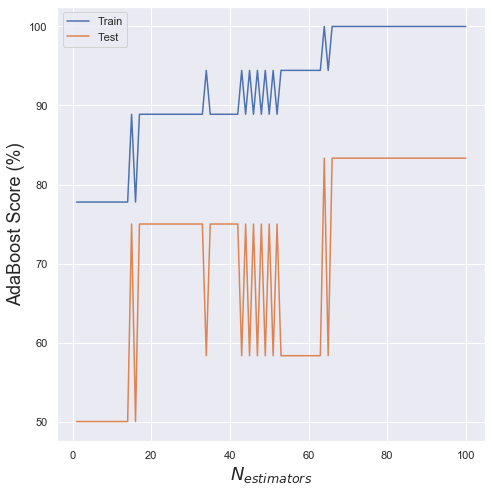

In [10]:
sc_train = 100*np.array(score_train)
sc_test = 100*np.array(score_test)

fig, ax = plt.subplots(figsize = (7, 7))
ax.plot(n_estimators, sc_train, label='Train')
ax.plot(n_estimators, sc_test, label='Test')
ax.set_xlabel('$N_{estimators}$',fontsize=18)
ax.set_ylabel('AdaBoost Score (%)',fontsize=18)

ax.legend(loc="upper left")
fig.tight_layout()

plt.savefig('12.1.3_weak_learner_scores_lambda_0.3.png')
plt.savefig('12.1.3_weak_learner_scores_lambda_0.3.pdf')

## How related are the training errors from the weak learners and the AdaBoost classifier?

When there is only one weak learner, both errors are identical (about 22%) since the classifiers are identical (figure below). 
As new estimators are added, the AdaBoost classifier gets better and its training error drops. 
On the other hand, each new weak learner has a harder time to classifying increasingly difficult data. Its training 
error increases as a result.


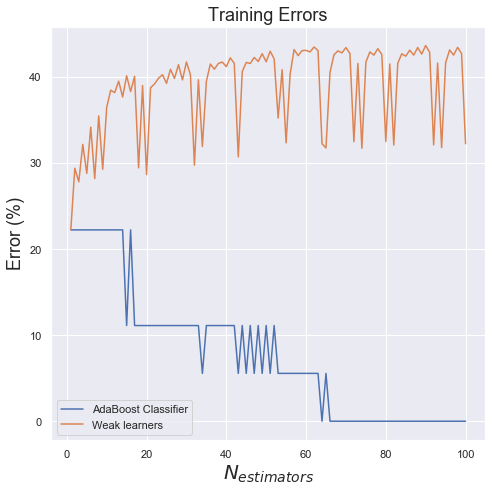

In [11]:
fig, ax = plt.subplots(figsize = (7, 7))
ax.plot(n_estimators, 100-sc_train, label='AdaBoost Classifier')
ax.plot(n_estimators, err, label='Weak learners')
ax.set_xlabel('$N_{estimators}$',fontsize=20)
ax.set_ylabel('Error (%)',fontsize=18)
ax.set_title('Training Errors',fontsize=18)
ax.legend(loc="lower left")
fig.tight_layout()

plt.savefig('12.1.4_weak_learners_vs_AdaBoost_scores_lambda_0.3.png')
plt.savefig('12.1.4_weak_learners_vs_AdaBoost_scores_lambda_0.3.pdf')

# What is the effect of the learning rate $\lambda$?

The learning rate is a useful parameter to show the optimization process. Let us use a small value, $\lambda=0.1$, with 
a large number of estimators to insure convergence. 

In [12]:
n_estimators = 300
learning_rate = .1
(classifiers_list, errors_list, weights_list, alpha_list) = AdaBoost(X_train, y_train, n_estimators, learning_rate)

(score_train, score_test) = AdaBoost_scores(classifiers_list, alpha_list, X_train, y_train, X_test, y_test)

The AdaBoost classifier takes more time to converge to constant training and test score values. The final training 
and test scores remain unchanged; 100% and 83% (lower panel). This happens at the end of the exponential phase, at 
iteration 225, instead of iteration 65, when using $\lambda=0.3$ 

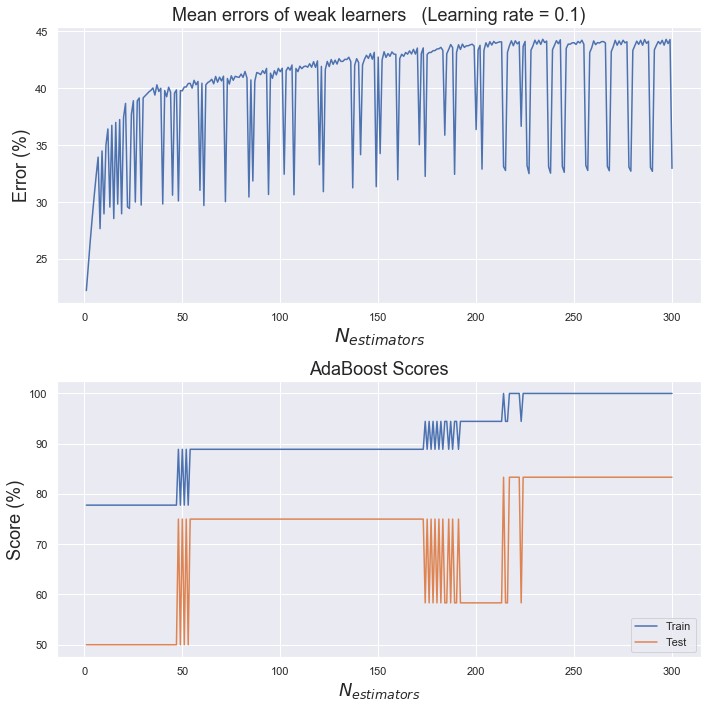

In [13]:
n_estimators = np.arange(1,len(errors_list)+1)
err = 100*np.array(errors_list)
sc_train = 100*np.array(score_train)
sc_test = 100*np.array(score_test)

fig, axs = plt.subplots(2,1,figsize = (10, 10))
axs[0].plot(n_estimators, err)
axs[0].set_xlabel('$N_{estimators}$',fontsize=20)
axs[0].set_ylabel('Error (%)',fontsize=18)
axs[0].set_title('Mean errors of weak learners   (Learning rate = %.1f)' % (learning_rate),fontsize=18)

axs[1].plot(n_estimators, sc_train, label='Train')
axs[1].plot(n_estimators, sc_test, label='Test')
axs[1].set_xlabel('$N_{estimators}$',fontsize=18)
axs[1].set_ylabel('Score (%)',fontsize=18)

axs[1].set_title('AdaBoost Scores',fontsize=18)
axs[1].legend(loc="lower right")

fig.tight_layout()
plt.savefig('12.1.5_weak_learner_errors_vs_AdaBoost_scores_lambda_0.1.png')
plt.savefig('12.1.5_weak_learner_errors_vs_AdaBoost_scores_lambda_0.1.pdf')

Now, let us use a larger value, $𝜆=1.0$ , with a small number of estimators since it rapidly converges.

In [14]:
n_estimators = 30
learning_rate = 1
(classifiers_list, errors_list, weights_list, alpha_list) = AdaBoost(X_train, y_train, n_estimators, learning_rate)

(score_train, score_test) = AdaBoost_scores(classifiers_list, alpha_list, X_train, y_train, X_test, y_test)

The AdaBoost classifier rapidly converges to constant score values. The 
final training and test scores remain unchanged, once again; 100% and 83% (lower panel). This happens after 
10 iterations only. 

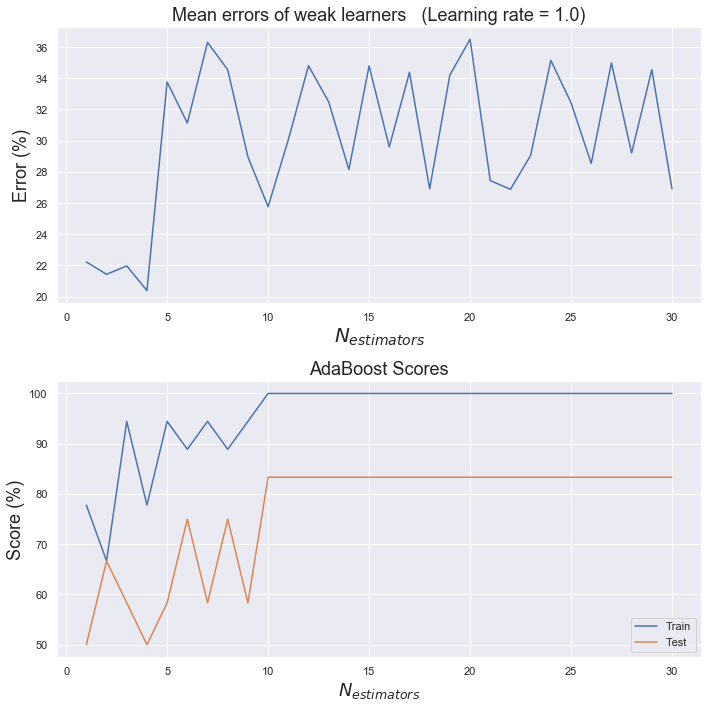

In [15]:

n_estimators = np.arange(1,len(errors_list)+1)
err = 100*np.array(errors_list)
sc_train = 100*np.array(score_train)
sc_test = 100*np.array(score_test)

fig, axs = plt.subplots(2,1,figsize = (10, 10))
axs[0].plot(n_estimators, err)
axs[0].set_xlabel('$N_{estimators}$',fontsize=20)
axs[0].set_ylabel('Error (%)',fontsize=18)
axs[0].set_title('Mean errors of weak learners   (Learning rate = %.1f)' % (learning_rate),fontsize=18)

axs[1].plot(n_estimators, sc_train, label='Train')
axs[1].plot(n_estimators, sc_test, label='Test')
axs[1].set_xlabel('$N_{estimators}$',fontsize=18)
axs[1].set_ylabel('Score (%)',fontsize=18)
axs[1].set_title('AdaBoost Scores',fontsize=18)
axs[1].legend(loc="lower right")

fig.tight_layout()
plt.savefig('12.1.6_weak_learner_errors_vs_AdaBoost_scores_lambda_1.0.png')
plt.savefig('12.1.6_weak_learner_errors_vs_AdaBoost_scores_lambda_1.0.pdf')

# What are the impacts of new estimators on the cumulative decision function?
Let us first define a plotting function that combines several types of information:

<ul>
<li>The training data
<li>Cumulative decision function</li>
<li>New estimator decision function</li>
<li>The sample weight associated to each data</li>
</ul>

Each new estimator decision function in shown in blue/green, upon which is 
superposed the cumulative decision function in yellow. Because the weak learner 
template is a single-branch decision tree, each new estimator decision function is vertical or horizontal.

The training data are displayed with circles with sizes corresponding to their weights. 


In [16]:
def plot_decision_boundary(classifiers_list, alpha_list, weights_list, m, X, y):
    # Generate a spatial grid where the class will be predicted locally.
    dX = X[:, 0].max() - X[:, 0].min()
    dY = X[:, 1].max() - X[:, 1].min()   
    
    x_min, x_max = X[:, 0].min() - 0.1*dX, X[:, 0].max() + 0.1*dX
    y_min, y_max = X[:, 1].min() - 0.1*dY, X[:, 1].max() + 0.1*dY
    
    N = 50
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    Xgrid = np.c_[xx.ravel(), yy.ravel()]
    
    # Cumulative model prediction
    Z_sum = 0.
    for k in range(m+1):
        z = classifiers_list[k].predict(Xgrid)
        z = z.reshape(1,-1)
        Z_sum += alpha_list[k]*z

    Z_sum = np.sign(Z_sum)    
    Z_sum = Z_sum.reshape(xx.shape)    
        
    # Current estimator prediction
    Z_estimator = np.sign(z)
    Z_estimator = Z_estimator.reshape(xx.shape)

    # Rescale weights for proper displaying
    weights = weights_list[m]
    eps = np.finfo(float).eps
    weights = 20*np.ones(len(weights)) + 70*(weights-weights.min())/(eps + weights.max()-weights.min())
    

    cm_dim = ListedColormap(['#00BB00', '#0000BB'])
    cm_bright = ListedColormap(['#00FF00', '#0000FF']) 

    ax = plt.gca()
    ax.contour(xx, yy, Z_sum, [0.0], linewidths=2, colors='yellow')      
    ax.contourf(xx, yy, Z_estimator, 2, cmap=cm_dim, alpha=.5)       
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = weights, edgecolors='k')
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$', rotation=0)


The next figure shows the class predictions for the first 12 weak-learner estimators. The cumulative prediction 
boundary (in yellow) barely changes after the 10th model (m=9) where the score curves levelled off in the last figure. 

In the first panel, notice how the four misclassified blue dots get larger weights in the second panel. Same thing 
about the six misclassified green dots in the second panel; they get larger weights in the third panel and so on.   

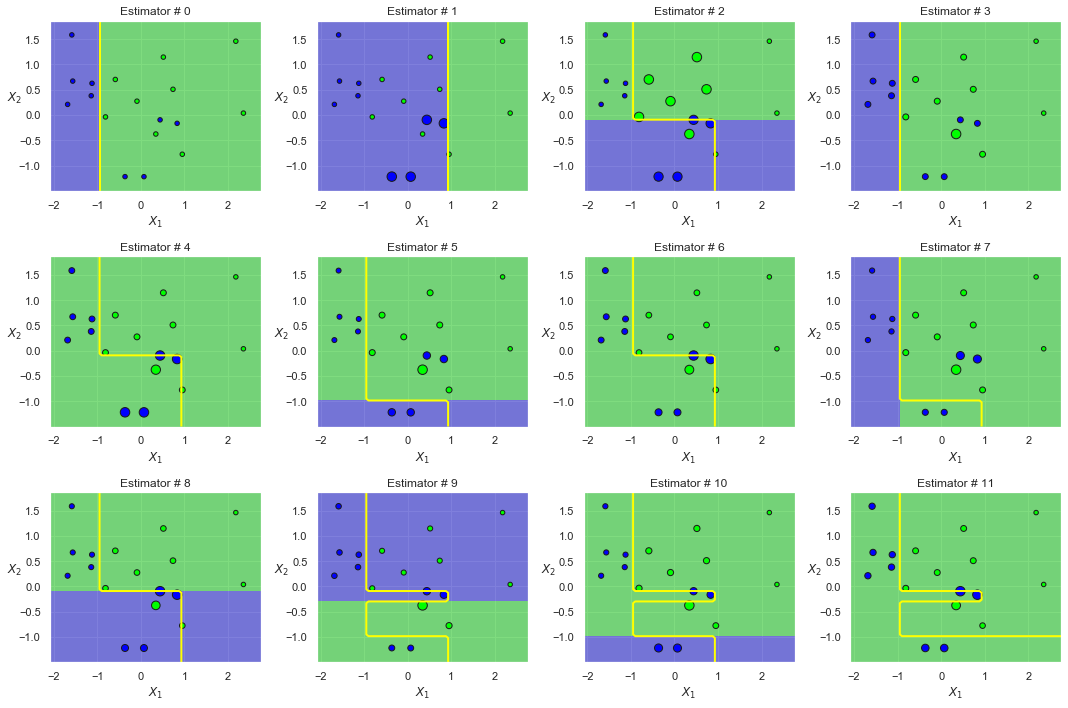

In [17]:
fig = plt.figure(figsize = (15,10))
for m in range(0,12):
    fig.add_subplot(3,4,m+1)
    
    plot_decision_boundary(classifiers_list, alpha_list, weights_list, m, X_train, y_train)
    plt.title('Estimator # {}'.format(m))
    
fig.tight_layout()
plt.savefig('12.1.7_weak_learner_and_AdaBoost_decision_boundaries_lambda_1.0.png')
plt.savefig('12.1.7_weak_learner_and_AdaBoost_decision_boundaries_lambda_1.0.pdf')

What are the final AdaBoost classification results after convergence? Let us first define a plotting function 
that shows them for a given learning rate value $\lambda$.

In [18]:
def plot_final_decision_boundary(classifiers_list, alpha_list, X, y):
    # Generate a spatial grid where the class will be predicted locally.
    dX = X[:, 0].max() - X[:, 0].min()
    dY = X[:, 1].max() - X[:, 1].min()    
    x_min, x_max = X[:, 0].min() - 0.1*dX, X[:, 0].max() + 0.1*dX
    y_min, y_max = X[:, 1].min() - 0.1*dY, X[:, 1].max() + 0.1*dY
    
    N = 50
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    Xgrid = np.c_[xx.ravel(), yy.ravel()]
    
    # Cumulative model prediction
    Z_sum = 0.
    for k, clf in enumerate(classifiers_list):
        z = clf.predict(Xgrid)
        z = z.reshape(1,-1)
        Z_sum += alpha_list[k]*z

    Z_sum = np.sign(Z_sum)    
    Z_sum = Z_sum.reshape(xx.shape) 

    
    cm_dim = ListedColormap(['#00BB00', '#0000BB'])
    cm_bright = ListedColormap(['#00FF00', '#0000FF'])
        
    ax = plt.gca()
    ax.contourf(xx, yy, Z_sum, 2, cmap=cm_dim, alpha=.5)    
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = 30, edgecolors='k')
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$', rotation=0)


Show the final AdaBoost classification for current values of $\lambda=1$, $N_{estimators}=30$. The same boundary shape 
can also be seen on the last panel of the previous figure. 

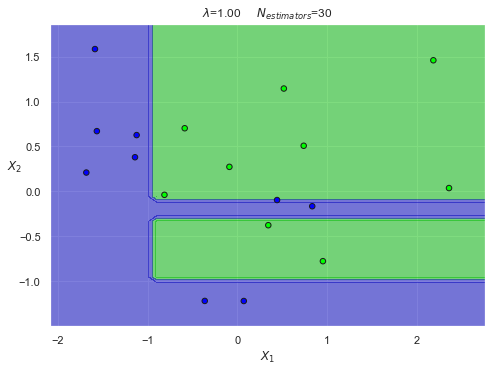

In [19]:
n_estimators = 30
learning_rate = 1.0

(classifiers_list, errors_list, weights_list, alpha_list) = AdaBoost(X_train, y_train, n_estimators, learning_rate)    

fig = plt.figure(figsize = (7,7))
plot_final_decision_boundary(classifiers_list, alpha_list, X_train, y_train)
plt.title('$\lambda$=%.2f     $N_{estimators}$=%d' % (learning_rate, n_estimators))

fig.tight_layout()
plt.savefig('12.1.8_AdaBoost_final_decision_boundaries_lambda_1.0.png')
plt.savefig('12.1.8_AdaBoost_final_decision_boundaries_lambda_1.0.pdf')

## What is the most useful; the learning rate or the number of estimators?
Both parameters can be used to find the optimal AdaBoost classification but they are somewhat redundant
and only one should be used. We used in this script the learning rate $\lambda$ as a usefull tool 
to visualize the optimization process. However, it should be kept constant (e.g. $\lambda=1$) and 
the number of estimators $N_{estimators}$ should be varied to obtain the best classification results, using
cross validation.

Let us generate a dataset with 10x more data as before to produce more complex classifications.

In [20]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

# Convert {0, 1} to {-1, 1} classes
y = 2*y-1

# Normalize the data
X = StandardScaler().fit_transform(X)

The figure below shows similar classification results using two combinations of learning rate and number of estimators. 
They are indeed redundant for classification purposes; we should keep the learning rate constant and adjust the number of 
estimators for our experimentations.  

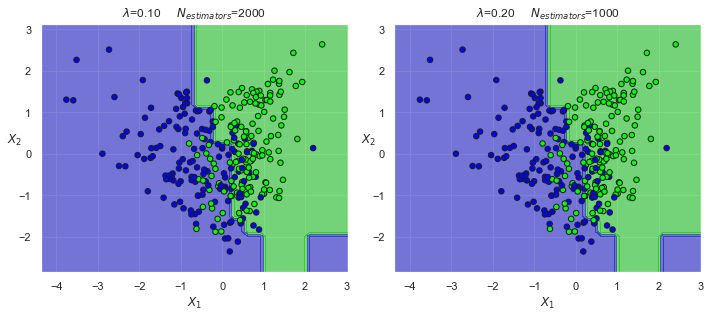

In [21]:
n_estimators = [2000, 1000]
learning_rate = [0.1, 0.2]

fig = plt.figure(figsize = (10,5))
for m in range(2):
    fig.add_subplot(1,2,m+1)

    (classifiers_list, errors_list, weights_list, alpha_list) = AdaBoost(X, y, n_estimators[m], learning_rate[m])    
    
    plot_final_decision_boundary(classifiers_list, alpha_list, X, y)
    plt.title('$\lambda$=%.2f     $N_{estimators}$=%d' % (learning_rate[m], n_estimators[m]))
    
fig.tight_layout()
plt.savefig('12.1.9_AdaBoost_decision_boundaries_various_lambda_and_N_estimators.png')
plt.savefig('12.1.9_AdaBoost_decision_boundaries_various_lambda_and_N_estimators.pdf')